In [1]:
import warnings
import os
import time
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.hub import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional
from collections import namedtuple

import matplotlib.pyplot as plt
from PIL import Image

import json
from tqdm import tqdm

import sys

sys.path.insert(0, "..") # to include ../helper_utils.py etc.
from helper_utils import set_all_seeds, set_deterministic

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

### parameter

In [2]:
random_seed = 123
learning_rate = 0.0001
batch_size = 8
epochs = 10

num_classes = 5

DEVICE = "cuda"

save_path = "resnet_flower.pth"

### setting

In [3]:
set_all_seeds(random_seed)

set_deterministic()

### data

In [4]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.RandomResizedCrop((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

image_path = "D:/work/data/Python/flower_data/"
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"), transform=train_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"), transform=test_transform)

flower_list = train_dataset.class_to_idx
class_dict = dict((val, key) for key, val in flower_list.items())

# dump dict too json file
json_str = json.dumps(class_dict, indent=4)
with open("class_indices.json", "w") as json_file:
    json_file.write(json_str)
#     json.dump(class_dict, json_file, ensure_ascii=False)

num_workers = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 0])
print('Using {} dataloader workers every process'.format(num_workers))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_num = len(train_dataset)
test_num = len(test_dataset)

print("train images num: ", train_num)
print("test images num: ", test_num)

for images, labels in train_loader:
    print("images shape: ", images.size())
    print("labels shape: ", labels.size())
    break

Using 0 dataloader workers every process
train images num:  3306
test images num:  364
images shape:  torch.Size([8, 3, 224, 224])
labels shape:  torch.Size([8])


### model

In [5]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-b627a593.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-0676ba61.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-63fe2227.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-394f9c45.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, dilation=1):
        super(BasicBlock, self).__init__()
        
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, dilation=1):
        super(Bottleneck, self).__init__()
        
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, groups=1, width_per_group=64,replace_stride_with_dilation=None):
        super(ResNet, self).__init__()
        
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation))

        return nn.Sequential(*layers)
    
    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
    def forward(self, x):
        return self._forward_impl(x)

def _resnet(arch, block, layers, pretrained=False, progress=False, **kwargs: Any):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = resnet50(num_classes=5)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda


### train

In [ ]:
best_acc = 0.0
# train_steps: train_num // batch_size
train_steps = len(train_loader)
for epoch in range(epochs):
    model.train()
    train_bar = tqdm(train_loader)
    running_loss = 0.0
    for step, (images, labels) in enumerate(train_bar):
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        logits = model(images)
        
        # backward
        optimizer.zero_grad()
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        
        # update
        optimizer.step()
        
        # logging
        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss)
    
    model.eval()
    correct = 0.0
    with torch.no_grad():
        test_bar = tqdm(test_loader)
        for images, labels in test_bar:
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            _, predict_labels = torch.max(logits, dim=1)
            correct += torch.eq(predict_labels, labels).sum().float()
    
    test_acc = correct / test_num
    train_loss = running_loss / train_steps
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, train_loss, test_acc))
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_path)
        print("save model pth to %s" % (save_path))
    
print("Finished training")

### evaluate

(332, 500, 3)
torch.Size([3, 224, 224])
class: tulips   prob: 0.528


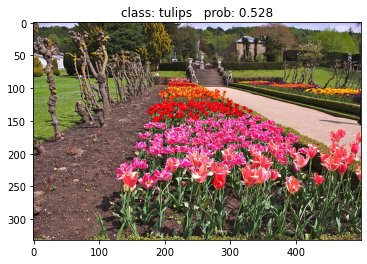

In [7]:
# load image
img_path = "D:/work/data/Python/flower_data/val/tulips/10995953955_089572caf0.jpg"
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path)

print(np.array(img).shape)
plt.imshow(img)
# [N, C, H, W]
img = test_transform(img)
print(img.shape)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

# read class_indict
json_path = './class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

json_file = open(json_path, "r")
class_indict = json.load(json_file)

# create model
model = resnet50(num_classes=5)
model.to(device)

# load model weights
weights_path = "./resnet_flower.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path))

model.eval()
with torch.no_grad():
    img = img.to(device)
    # logits shape: (1, 5)
    logits = model(img)
    logits = torch.squeeze(logits).cpu()
    predict = torch.softmax(logits, dim=0)
    # if want to use numpy(), the tensor must be on cpu
    predict_class = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_class)],
                                             predict[predict_class].numpy())
plt.title(print_res)
print(print_res)
plt.show()